### Import necessary libraries

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, precision_score, f1_score, roc_auc_score, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

### Check if GPU is available or not

In [9]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Test Model with New Data (Unseen Data)

In [2]:
dataset_path = "../../dataset/ctscan/3A_images_resized/expert_dataset/"

In [14]:
# Load the saved model
model_name = "./models/ctscan_vgg16net_64_20_expert_acc_99.3.h5"
# model_name = "./models/learned_policy_human_expert_rollout_10.h5"
model = load_model(model_name)

In [4]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)

In [5]:
test_datagen = ImageDataGenerator(
  rescale=1./255,
  # rotation_range=10,
  # width_shift_range=0.1,
  # height_shift_range=0.1,
  # shear_range=0.1,
  # zoom_range=0.1,
  # horizontal_flip=True,
  # fill_mode='nearest'
)

In [6]:
test_generator = test_datagen.flow_from_directory(
  dataset_path + "test",
  target_size=IMAGE_SIZE
)

Found 2000 images belonging to 3 classes.


In [7]:
num_classes = test_generator.num_classes
class_names = list(test_generator.class_indices.keys())
print("Total classes:", num_classes, class_names)

Total classes: 3 ['Covid19', 'Normal', 'Pneumonia']


In [8]:
test_data, test_labels = [], []
for _ in range(len(test_generator)):
    batch_data, batch_labels = test_generator.next()
    test_data.append(batch_data)
    test_labels.append(batch_labels)

test_data = np.concatenate(test_data)
test_labels = np.concatenate(test_labels)

In [15]:
# Make predictions on the test set
test_predictions = model.predict(test_data)

63/63 [==============================] - 3s 43ms/step


63/63 [==============================] - 3s 44ms/step - loss: 0.5253 - accuracy: 0.9335


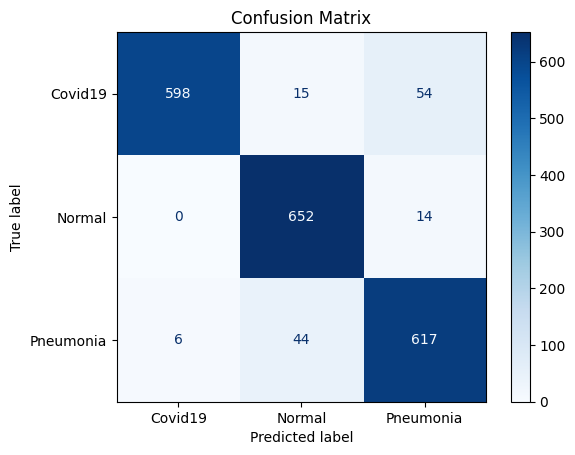

Accuracy: 0.9334999918937683
Loss: 0.5252657532691956
Precision: 0.9349023535302955
F1 Score: 0.9342006504878659
AUC-ROC Score: 0.973073125
Confusion Matrix:
[[598  15  54]
 [  0 652  14]
 [  6  44 617]]


In [17]:
### Convert predicted probabilities to predicted class labels
test_predicted_labels = (test_predictions > 0.5).astype(np.int8)  # Thresholding at 0.5

p_l = [np.where(x == 1)[0][0] if np.where(x == 1)[0].size > 0 else 0 for x in test_predicted_labels]
t_l = [np.where(x == 1)[0][0] for x in test_labels]

test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))

# Calculate precision
precision = precision_score(test_labels, test_predicted_labels, average='micro')

# Calculate F1 score
f1 = f1_score(test_labels, test_predicted_labels, average='micro')

# Calculate AUC-ROC
auc_roc = roc_auc_score(test_labels, test_predictions, average='micro')

# Calculate confusion matrix
# conf_matrix = multilabel_confusion_matrix(test_labels, test_predicted_labels)
conf_matrix = confusion_matrix(t_l, p_l)


disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy:", test_accuracy)
print("Loss:", test_loss)
print("Precision:", precision)
print("F1 Score:", f1)
print("AUC-ROC Score:", auc_roc)
print("Confusion Matrix:")
print(conf_matrix)

### Print Model Summary

In [22]:
# model.summary()